# Model A Basic (Multi-class): Stage 1 vs 2 vs 3

Simple 3-class classification without feature engineering.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

In [2]:
# Load Data
df = pd.read_csv('cirrhosis.csv')

if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

df = df.dropna(subset=['Stage'])
df_basic = df[df['Stage'].isin([1, 2, 3])].copy()

print(f"Shape: {df_basic.shape}")
print("\nStage Distribution:")
print(df_basic['Stage'].value_counts().sort_index())

Shape: (25000, 19)

Stage Distribution:
Stage
1    8265
2    8441
3    8294
Name: count, dtype: int64


## 1. Target Definition (Multi-class)
**Stage 1 vs Stage 2 vs Stage 3**

In [3]:
# Multi-class target: 0, 1, 2 (for Stages 1, 2, 3)
df_basic['Target'] = df_basic['Stage'] - 1

print("Target Distribution:")
print(df_basic['Target'].value_counts().sort_index())

Target Distribution:
Target
0    8265
1    8441
2    8294
Name: count, dtype: int64


## 2. Features (No Engineering)

In [4]:
# Same features as binary model
feature_cols = [ 'Ascites', 'Hepatomegaly', 
                'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin',
                'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

X = df_basic[feature_cols].copy()
y = df_basic['Target']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Features: {len(feature_cols)}")
print(f"Categorical: {len(categorical_cols)}, Numerical: {len(numeric_cols)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

Features: 13
Categorical: 4, Numerical: 9

Train: (20000, 13), Test: (5000, 13)


## 3. Optuna Tuning (Multi-class)

In [5]:
print("Starting Optuna Tuning (Multi-class)...")

# RF
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'class_weight': 'balanced'
    }
    model = RandomForestClassifier(**param, random_state=42, n_jobs=-1)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10)
best_rf_params = study_rf.best_params
best_rf_params['class_weight'] = 'balanced'

# XGB (multi-class)
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'objective': 'multi:softprob',
        'num_class': 3
    }
    model = XGBClassifier(**param, random_state=42, verbosity=0)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=10)
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'use_label_encoder': False, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'num_class': 3})

# LGBM (multi-class)
def objective_lgbm(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'class_weight': 'balanced',
        'objective': 'multiclass',
        'num_class': 3,
        'verbose': -1
    }
    model = LGBMClassifier(**param, random_state=42)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=10)
best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({'class_weight': 'balanced', 'objective': 'multiclass', 'num_class': 3, 'verbose': -1})

print("Best params obtained!")

Starting Optuna Tuning (Multi-class)...


Best params obtained!


## 4. Ensemble & Evaluation

Training ensemble...

Classification Report:
              precision    recall  f1-score   support

     Stage 1       0.96      0.95      0.96      1653
     Stage 2       0.94      0.96      0.95      1688
     Stage 3       0.98      0.97      0.97      1659

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000


Macro F1-Score: 0.9599


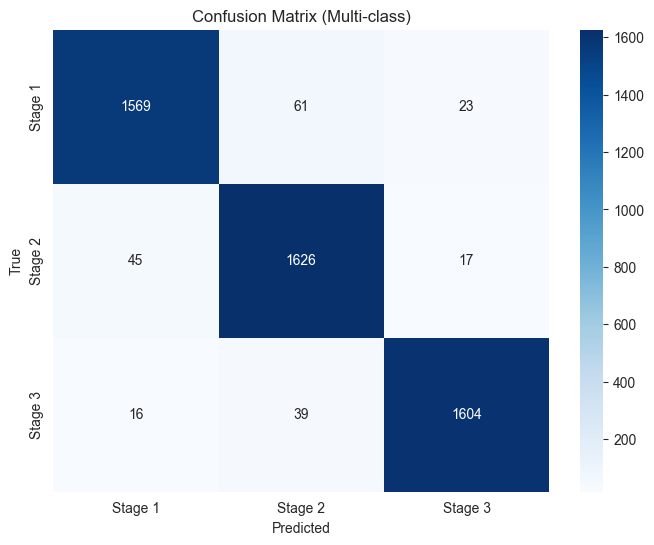

In [6]:
# Ensemble
model_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', model_rf), ('xgb', model_xgb), ('lgbm', model_lgbm)],
    voting='soft'
)

final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble)
])

print("Training ensemble...")
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Stage 1', 'Stage 2', 'Stage 3']))
print(f"\nMacro F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stage 1', 'Stage 2', 'Stage 3'], yticklabels=['Stage 1', 'Stage 2', 'Stage 3'])
plt.title('Confusion Matrix (Multi-class)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()